# <font color="dodgerblue">Distance-Based Blurring for Computer Vision Final Project - FULL DATASET VERSION</font>

**<font color="teal">Author:</font>** Teague Sangster

**<font color="teal">Date Updated:</font>** May 12, 2025

**<font color="teal">Description:</font>** Here we simulate our Camera!!!!! Long story short this Jupyter Notebook processes a full dataset of images (from the KITTI dataset or a similar format) to apply a depth of field effect. The core idea is to simulate how a camera with a specific focal plane would capture a scene, blurring objects that are further or nearer than the in-focus distance.

There are more in depth explanations above each section so look at those! But for now here's a general outline of simulating our Camera. 

---

### <font color="darkorange">Overview of the Process:</font>

1.  **<font color="slateblue">Setup and Configuration:</font>**
    * Imports necessary libraries for image processing (OpenCV, NumPy), object detection (<font color="green">YOLOv8 via Ultralytics, PyTorch</font>), file handling (`os`, `pathlib`), parallel processing, and visualization (`matplotlib`).
    * Configures the computation device (CPU or <font color="green">Apple MPS</font> for GPU acceleration).
    * Sets up file paths for input images, KITTI-style label files (containing object distances and bounding boxes), and the output directory for blurred images.

2.  **<font color="slateblue">Distance Calibration:</font>**
    * Parses all KITTI label files to extract the 3D location (specifically the z-coordinate or depth) of every labeled object.
    * Calculates statistics on these distances (min, max, mean) and determines an `effective_min` and `effective_max` focus distance by handling outliers using percentiles. <font color="chocolate">This step is crucial for defining the "best-case scenario camera" focus for the dataset.</font>

3.  **<font color="slateblue">Depth of Field (DoF) Effect Application:</font>**
    * Initializes a <font color="green">YOLOv8 segmentation model</font> to identify and create masks for objects in the images.
    * **Focus Plane Simulation:** For each image, a "focus plane" is simulated. The distance that is perfectly in focus changes linearly from the top of the image (furthest focused distance) to the bottom (nearest focused distance), mimicking a tilted sensor or a specific photographic effect.
    * **Object-Specific Blurring:**
        * The script first applies a general background blur.
        * Objects identified as being "perfectly in focus" (based on their labeled distance and the simulated focus plane) are kept sharp, with soft blended edges using transition masks.
        * For other objects, their KITTI-labeled distance is compared to the focus plane distance at their location.
        * The YOLO model provides segmentation masks and refined bounding boxes for these objects.
        * A blur sigma is calculated based on how far an object is from the in-focus plane.
        * An internal "depth mask" is created for each object, allowing for a gradual transition between focused and blurred parts *within* the object itself, enhancing realism.
        * The blurred (or partially blurred) object is then carefully blended back into the main image using its YOLO segmentation mask.

4.  **<font color="slateblue">Parallel Processing and Output:</font>**
    * The entire dataset is processed image by image, leveraging multi-threading (`ThreadPoolExecutor`) to speed up the task.
    * Each processed (blurred) image is saved to the specified output directory.
    * A summary of the processing (number of successful and failed images) is provided.

5.  **<font color="slateblue">Visualization:</font>**
    * Finally, a few sample images (original vs. blurred) are displayed using `matplotlib` to provide a quick visual check of the results.

---

### <font color="darkorange">Purpose/Goal:</font>
The primary aim is to generate a dataset of images with a realistic depth of field blur. This can be used for various computer vision tasks, such as <font color="green">training models to be more robust to DoF effects, data augmentation, or simulating specific camera properties</font> for research or artistic purposes. The use of YOLO ensures that object boundaries are respected during the blurring process, leading to more accurate and visually plausible results.

### Cell 2: Importing Libraries, Setting File Paths, and Output Directory Creation

This cell is responsible for setting up the foundational elements of the script.

**1. Importing Libraries:**
The following libraries are imported to provide necessary functionalities:

* `os`: Used for interacting with the operating system, particularly for tasks like file path manipulation and directory creation.
* `numpy`: Essential for numerical operations, especially when working with image data which is often represented as arrays.
* `cv2` (OpenCV): A core computer vision library used here for image reading (`imread`), writing (`imwrite`), and various image manipulation tasks required for the blurring effect.
* `pathlib`: Provides an object-oriented way to handle file system paths, used here to manage file opening and saving operations.
* `matplotlib.pyplot`: A widely-used plotting library. In this context, and particularly in earlier versions of the code, it was crucial for visualizing results and ensuring the distance blur rate was correctly implemented.
* `tqdm`: Used for displaying progress bars, which is helpful for monitoring the status of long-running iterative tasks like processing multiple images.
* `ultralytics` and `YOLO`: These are for object detection and segmentation using the YOLO (You Only Look Once) model. This is included to verify if objects are still discernible after the blurring process or if the blur is too aggressive. The specific version of YOLO was chosen for its compatibility with hardware acceleration on the developer's Mac.
* `torch` (PyTorch): A deep learning framework that YOLO utilizes for its underlying functionalities.
* `concurrent.futures.ThreadPoolExecutor` and `multiprocessing`: These libraries are imported to enable parallel processing. While processing a single image might be quick, these were included with foresight to speed up the processing of large datasets or if future enhancements made individual image processing more time-consuming.

**2. Path Settings:**
String variables are defined to hold the absolute paths for:
* `LABEL_DIR`: The directory containing the KITTI label files (which provide ground truth information about objects in the images).
* `IMAGE_DIR`: The directory where the original training images are stored.
* `OUTPUT_DIR`: The directory designated for saving the processed (blurred) output images.

**3. Output Directory Creation:**
The script checks if the `OUTPUT_DIR` exists. If it does not, `os.makedirs(OUTPUT_DIR, exist_ok=True)` creates it. The `exist_ok=True` argument prevents an error if the directory already exists, ensuring the script can run smoothly without manual directory creation beforehand. This guarantees a location is ready for the processed images.

In [ ]:
# Distance-Based Blurring for Computer Vision Final Project - FULL DATASET VERSION
# Author: Teague Sangster
# Description: Process ALL images with depth of field effect

import os
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import ultralytics
from ultralytics import YOLO
import torch
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

# Set paths
LABEL_DIR = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/training/label_2"
IMAGE_DIR = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/data_object_image_2/training/image_2"
OUTPUT_DIR = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/BlurredImages/BlurredTrainingData"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Cell 3: Code - Device Configuration for PyTorch (CPU/MPS)

This cell is dedicated to optimizing the performance of PyTorch operations, particularly for the YOLO model, by leveraging available hardware acceleration.

**Objective: Hardware Acceleration for YOLO**
The primary goal here was to ensure that the computationally intensive tasks performed by PyTorch (which underpins the YOLO model) could be hardware-accelerated on my laptop, specifically the GPU. Using PyTorch with Metal Performance Shaders (MPS) is not per say needed but really helps here for speeding it up

**Functionality:**
* **Device Detection:** The code checks if Metal Performance Shaders (MPS) are available. MPS is Apple's framework for GPU-accelerated computations on M-series chips.
    * If `torch.backends.mps.is_available()` returns `True`, the `device` variable is set to `"mps"`. This tells PyTorch to utilize my laptops GPU .
    * If MPS is not available (e.g., on a different operating system or hardware), the `device` defaults to `"cpu"`.
* **Confirmation:** Just printing everytime as im worried it isn't using whenever im debugging

In [ ]:

# Enable Metal Performance Shaders for M3 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

### Cell 4: Code - KITTI Label Parsing Functions

This cell defines two functions to handle KITTI dataset labels:

1.  **`parse_kitti_label(label_path)`**:
    * Which handles an individual ground truth label, Expected in the form of .txt. For each line that doesn't cover a don't care object it will parse all of the information of it.
    * *Note: We are using don't cares as we only have enough information to correctly train a few object classes.*

2.  **`collect_all_distances()`**:
    * This function iterates through all .txt label files in the `LABEL_DIR`.
    * For each file, it uses the aforementioned `parse_kitti_label` to get object info and pays special attention to depth. In our dataset this is held as a our Z coordinate in the 'location' data for each object.
    * Importantly It collects only positive distances (objects in front of the camera) and returns them as a NumPy array.

In [1]:
# Parse KITTI Labels and Extract Distances
# This cell defines two functions to handle KITTI dataset labels:
def parse_kitti_label(label_path):
    # Which handles an individual ground truth label, Expected in the
    # form of .txt. For each line that doesn't cover a don't care
    # object it will parse all of the information of it.
    """Parse a single KITTI label file and extract object information."""
    objects = [] # Initialize an empty list to store object data

    with open(label_path, 'r') as f: # Open the label file for reading
        for line in f: # Iterate over each line in the file
            parts = line.strip().split() # Remove whitespace and split the line into parts
            # Check if the line has enough parts (at least 15) and is not a 'DontCare' object
            # Note: We are using don't cares as we only have enough
            # information to correctly train a few object classes.
            if len(parts) >= 15 and parts[0] != 'DontCare':
                # Create a dictionary to store object properties
                obj = {
                    'type': parts[0], # Object type (e.g., 'Car', 'Pedestrian')
                    'truncated': float(parts[1]), # Truncation level (0-1)
                    'occluded': int(parts[2]),    # Occlusion level (0-3)
                    'alpha': float(parts[3]),     # Observation angle
                    'bbox': (float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])), # 2D bounding box (left, top, right, bottom)
                    'dimensions': (float(parts[8]), float(parts[9]), float(parts[10])), # 3D dimensions (height, width, length)
                    'location': (float(parts[11]), float(parts[12]), float(parts[13])),    # 3D location (x, y, z) in camera coordinates
                    'rotation_y': float(parts[14]) # Rotation around Y-axis
                }
                objects.append(obj) # Add the parsed object to the list
    
    return objects # Return the list of parsed objects

def collect_all_distances():
    # This function iterates through all .txt label files in the LABEL_DIR.
    """Collect distances from all KITTI label files."""
    distances = [] # Initialize an empty list to store distances

    # Iterate over each file in the specified LABEL_DIR
    for label_file in os.listdir(LABEL_DIR):
        if label_file.endswith('.txt'): # Process only .txt files
            label_path = os.path.join(LABEL_DIR, label_file) # Construct the full path to the label file
            # For each file, it uses the aforementioned parse_kitti_label
            # to get object info and pays special attention to depth.
            objects = parse_kitti_label(label_path) # Parse the objects from the current label file
            
            for obj in objects: # Iterate over each object found in the file
                # Extract the z-coordinate (forward distance)
                # In our dataset this is held as a our Z coordinate in the 'location'
                # data for each object.
                distance = obj['location'][2]
                # Importantly It collects only positive distances (objects in
                # front of the camera)
                if distance > 0:  # Only consider objects in front of the camera
                    distances.append(distance) # Add the positive distance to the list
    
    # returns them as a NumPy array.
    return np.array(distances)

### Cell 5: Code - Distance Statistics and YOLO Model Initialization

This cell has a really important job: to figure out what kind of "camera focus" would work best for our dataset.
Long story short, we're doing this blurring to simulate an artifact caused by a modified camera we're working with. To do that, we need to know what kind of "focus" this simulated camera should have. In order to create a "best-case scenario camera" for this dataset, we first find out the minimum and furthest practical focus distances based on the objects present. The blurring is then applied relative to these distances, mimicking our modified camera's blur rate but within a "perfect depth" situation for this specific dataset.

**Function List:**

1.  **Distance Statistics:**
    * It calls `collect_all_distances()` to get all object distances from the labels.
    * Calculates and prints basic statistics: the raw minimum, maximum, and mean distances of objects.
    * To handle potential outliers in the distance data (objects that are extremely close or far), it calculates the 2nd and 98th percentiles of these distances.
    * It then determines an `effective_min` and `effective_max` distance using the range *inside* these outlier percentages. This is key because it helps us define a camera that's really good for *this dataset* but not unreasonably perfect to the point where all objects would be perfectly focused (and thus unblurred). These effective min/max values are also printed for review.

2.  **YOLO Model Initialization:**
    * It initializes the YOLO v8 segmentation model. This is done by loading pretrained weights from the file 'yolov8n-seg.pt'.
    * The model is then moved to the device that was configured back in Cell 3 (either MPS for Apple GPU acceleration or CPU).
    * Hopefully, a success message is printed to confirm the model loaded correctly!

In [ ]:
# Collect all distances for calibration
# This cell has a really important job: to figure out what kind of
# "camera focus" would work best for our dataset. Long story short,
# we're doing this blurring to simulate an artifact caused by a modified
# camera we're working with. To do that, we need to know what kind of
# "focus" this simulated camera should have. In order to create a
# "best-case scenario camera" for this dataset, we first find out the
# minimum and furthest practical focus distances based on the objects
# present. The blurring is then applied relative to these distances,
# mimicking our modified camera's blur rate but within a "perfect depth"
# situation for this specific dataset.

# ---- Distance Statistics ----
print("Collecting distances from all labels...")
# It calls collect_all_distances() to get all object distances from the labels.
distances = collect_all_distances()

# Calculate statistics
# Calculates and prints basic statistics: the raw minimum, maximum, and mean distances of objects.
mean_distance = np.mean(distances)
min_distance = np.min(distances)
max_distance = np.max(distances)

# Handle outliers (98% percentile rule)
# To handle potential outliers in the distance data (objects that
# are extremely close or far), it calculates the 2nd and 98th
# percentiles of these distances.
percentile_98 = np.percentile(distances, 98)
percentile_2 = np.percentile(distances, 2)

# Use percentiles if they're significantly different from raw min/max
# It then determines an effective_min and effective_max
# distance using the range *inside* these outlier
# percentages. This is key because it helps us define a camera
# that's really good for *this dataset* but not
# unreasonably perfect to the point where all objects would be
# perfectly focused (and thus unblurred). These effective min/max
# values are also printed for review.
if (max_distance - percentile_98) > (percentile_98 - percentile_2) * 0.5:
    effective_max = percentile_98
else:
    effective_max = max_distance

if (percentile_2 - min_distance) > (percentile_98 - percentile_2) * 0.5:
    effective_min = percentile_2
else:
    effective_min = min_distance

print(f"Distance Statistics:")
print(f"Raw Min: {min_distance:.2f}, Max: {max_distance:.2f}")
print(f"Effective Min: {effective_min:.2f}, Max: {effective_max:.2f}")
print(f"Mean: {mean_distance:.2f}")
print(f"98th percentile: {percentile_98:.2f}")

# ---- YOLO Model Initialization ----
print("Initializing YOLO v8 model...")
try:
    # It initializes the YOLO v8 segmentation model. This is done by
    # loading pretrained weights from the file 'yolov8n-seg.pt'.
    model = YOLO('yolov8n-seg.pt')  # Load segmentation model
    # The model is then moved to the device that was configured back
    # in Cell 3 (either MPS for Apple GPU acceleration or CPU).
    model.to(device)
    # Hopefully, a success message is printed to confirm the model
    # loaded correctly!
    print("YOLO model loaded successfully")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    raise

### Cell 6: Code - Depth of Field Effect Helper Functions

This cell defines several functions that are crucial for creating the depth of field (DoF) effect. To *fully* understand how this effect is applied, please read the paper linked in the Readme. Pay special attention to `calculate_focus_plane_distance` and `calculate_iou` as these are the most important in understanding how blurring was sectioned off.

1.  **`calculate_focus_plane_distance(y_coord, image_height, min_dist, max_dist)`**:
    * This function determines the distance that should be perfectly in focus at a given vertical (Y) coordinate in the image. (This is simulating the "off by 45 Degrees" part of our sensor).
    * The top of the image (y=0) corresponds to the `max_dist` (which you can think of as the furthest plane of focus), and the bottom of the image (y=`image_height`) corresponds to the `min_dist` (the nearest plane of focus).
    * Again, because our simulated camera isn't perfect, some objects are never fully in that "perfect focus" range, but that's okay – real life is never perfect either!

2.  **`calculate_blur_sigma(distance, min_dist, max_dist, max_sigma=15, blur_start_factor=0.3)`**:
    * This calculates the standard deviation (sigma) for the Gaussian blur that will be applied. Here, we vary the amount of blur depending on the object's distance. This is important to represent visual distortions up the image, much like the ones we see in our modified camera.
    * The amount of blur depends on how far the object's actual `distance` is from the `min_dist`.
    * Objects closer than a "blur start distance" (which is defined by `blur_start_factor` relative to `min_dist` and `max_dist`) receive no blur at all.
    * For objects further away, the blur sigma increases linearly, up to a `max_sigma`.
    * *To replicate our dataset, you'll probably have to mess with your sigma values to get a realistic blur application across all your distances.*

3.  **`create_depth_mask(obj_bbox, obj_distance, image_height, min_dist, max_dist)`**:
    * For a given object (defined by its bounding box `obj_bbox` and its `obj_distance`), this function creates a grayscale mask that's the same size as the object's bounding box.
    * For each row of pixels within this bounding box, it calculates the `focus_distance` (using the `calculate_focus_plane_distance` function).
    * If the `obj_distance` is close to this `focus_distance` (within a certain `tolerance`), that row in the mask is set to white (1.0, meaning it's in focus).
    * Otherwise, it uses a gradual falloff to assign gray values. This creates a smooth transition between the focused and blurred parts *within the object itself*, which is pretty neat for realism.

4.  **`calculate_iou(bbox1, bbox2)`**:
    * IOU bounding! This stands for Intersection over Union.
    * It's a standard function that calculates the overlap between two bounding boxes. This is super useful to match the KITTI ground truth object labels with the detections made by YOLO (so we can make sure we're masking the correct section of the image for each object).

5.  **`create_transition_mask(bbox, image_shape, transition_width=10)`**:
    * This function creates a mask for an object's bounding box but with soft edges.
    * It starts by making a mask where the object area is 1.0 (white).
    * Then, it applies a Gaussian blur to feather out those edges, with the amount of feathering controlled by `transition_width`.
    * Basically, this is for taking the "hard edge" off objects that might have been left slightly too much in focus, making the blend between sharp and blurred areas look more natural.

In [ ]:
# Create Depth of Field Effect Functions
def calculate_focus_plane_distance(y_coord, image_height, min_dist, max_dist):
    """
    Calculate the in-focus distance at a given Y coordinate.
    Uses linear relationship: distance = m * y + b where m = sqrt(2)/2
    This function determines the distance that should be perfectly in focus at a given vertical (Y) coordinate.
    (Simulating the off by 45 Degrees part of our sensor).
    """
    # Calculate the focus distance properly
    y_from_top = y_coord  # y=0 at top, y=image_height at bottom
    distance_range = max_dist - min_dist # The total range of distances we are considering for focus

    # Linear interpolation from top to bottom
    # y=0 (top) should map to max_dist (farthest plane of focus)
    # y=image_height (bottom) should map to min_dist (nearest plane of focus)
    # Again because our simulated camera isn't perfect it some objects are never in that range, but real life is never perfect.
    focus_distance = max_dist - (y_from_top / image_height) * distance_range

    # Ensure the calculated focus distance stays within the defined min_dist and max_dist
    return np.clip(focus_distance, min_dist, max_dist)

def calculate_blur_sigma(distance, min_dist, max_dist, max_sigma=15, blur_start_factor=0.3):
    """
    Calculate blur sigma based on distance from the in-focus plane.
    Here we vary the amount of blur depending on the distance, this is important to represent visual distortions.
    The amount of blur depends on how far the object's actual distance is from the min_dist.
    """
    distance_range = max_dist - min_dist
    if distance_range == 0: # If there's no range, there's no basis for varying blur
        return 0

    # Calculate the "blur start" distance: objects closer than this will not be blurred.
    # This is defined by blur_start_factor relative to min_dist and max_dist.
    blur_start_dist = min_dist + (distance_range * blur_start_factor)

    # No blur if within the sharp zone (closer than the blur_start_dist)
    if distance < blur_start_dist:
        return 0

    # Calculate how far the object is from the point where blurring starts
    dist_from_start = distance - blur_start_dist
    # The remaining range over which blur intensity will increase
    remaining_range = max_dist - blur_start_dist

    if remaining_range <= 0: # If no remaining range, no further blur increase
        return 0

    # Linear relationship for blur sigma from blur start to max distance.
    # Normalized distance within the blurring range (0 to 1).
    normalized_dist = dist_from_start / remaining_range
    # Sigma increases with normalized_dist, capped at max_sigma.
    # To Replicate our dataset you probably have to mess with your sigma values.
    return min(normalized_dist * max_sigma, max_sigma)

def create_depth_mask(obj_bbox, obj_distance, image_height, min_dist, max_dist):
    """
    Create a mask showing which parts of the object should be in focus.
    For a given object, this creates a grayscale mask of the same size as its bounding box.
    """
    x1, y1, x2, y2 = map(int, obj_bbox) # Get bounding box coordinates
    mask_height = y2 - y1
    mask_width = x2 - x1

    # If the bounding box has no area, return a minimal zero mask
    if mask_height <= 0 or mask_width <= 0:
        return np.zeros((1, 1), dtype=np.float32)

    # Initialize an empty mask (all zeros, meaning all blurred initially)
    mask = np.zeros((mask_height, mask_width), dtype=np.float32)

    # Iterate over each row of pixels within the object's bounding box
    for local_y in range(mask_height):
        global_y = y1 + local_y # Convert local y in bbox to global y in image
        # Calculate the ideal focus distance for this specific row
        focus_distance = calculate_focus_plane_distance(global_y, image_height, min_dist, max_dist)

        # Increased tolerance (in meters) for what's considered in focus
        tolerance = 3.0
        # If the object's actual distance is close to the focus distance for this row (within tolerance)
        if abs(obj_distance - focus_distance) < tolerance:
            mask[local_y, :] = 1.0 # Set this row in the mask to 1.0 (white, fully in focus)
        else:
            # If outside tolerance, calculate a gradual falloff for a smooth transition
            diff = abs(obj_distance - focus_distance)
            # Value decreases from 1 to 0 as the difference increases beyond tolerance
            value = max(0, 1 - (diff - tolerance) / (tolerance * 2))
            mask[local_y, :] = value # Assign the calculated gray value to this row
    
    return mask

def calculate_iou(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    This is used to match KITTI ground truth object labels with YOLO detections.
    (So we can make sure we're masking the correct section)
    """
    # Unpack bounding box coordinates (min_x, min_y, max_x, max_y)
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    # Calculate coordinates of the intersection rectangle
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    # If there's no overlap, intersection area is 0, so IoU is 0.0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate intersection area
    intersection = (x_right - x_left) * (y_bottom - y_top)
    # Calculate areas of individual bounding boxes
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    # Calculate union area
    union = area1 + area2 - intersection

    # If union is 0 (e.g., both boxes have no area), IoU is 0.0 to avoid division by zero
    if union == 0:
        return 0.0

    # Calculate and return IoU
    return intersection / union

def create_transition_mask(bbox, image_shape, transition_width=10):
    """
    Create a mask with soft edges for blending at object boundaries.
    Basically taking the edge off on objects left slightly too much in focus.
    """
    height, width = image_shape[:2] # Get image dimensions
    x1, y1, x2, y2 = map(int, bbox)   # Get object bounding box coordinates

    # Create a mask for the object, initialized to zeros
    mask = np.zeros((height, width), dtype=np.float32)

    # Fill the object area in the mask with 1.0 (white)
    mask[y1:y2, x1:x2] = 1.0

    # Create soft edges using Gaussian blur if transition_width is specified
    if transition_width > 0:
        # (0,0) for kernel size means it's computed from sigma (transition_width here)
        mask = cv2.GaussianBlur(mask, (0, 0), transition_width)

    return mask

### Cell 7: Code - Main Depth Blur Application Function: `apply_depth_blur`

This cell defines the core function, `apply_depth_blur`, which processes an image to create the Depth of Field (DoF) effect. We have labeling tags from the dataset, so we know which objects need to be taken care of. The hard part comes in segmenting those sections from their background. Luckily, we have YOLO to help us, which gives us the mask so we can clip them out.

**1. Perfect Focus Handling Steps:**

* It first identifies "perfectly focused objects" by comparing their KITTI-labeled distance to the calculated focus plane distance at the top, middle, and bottom of their bounding boxes. We don't want to blur objects in the correct position!
* For each in-focus object, a cutout is made, and then a `transition_mask` (with soft edges) is generated. These are combined into an overall `perfect_focus_mask`. This ensures that areas occupied by perfectly focused objects (and their soft edges) remain sharp.

**2. Background Blurring:**

* It applies a `base_blur` to the entire image (calculated using `calculate_blur_sigma` for the `max_dist`). This can be tuned and is what determines how everything out-of-focus looks.
* This blurred background is then blended with the original image using the `perfect_focus_mask`. Areas marked in the mask (perfectly focused objects) retain pixels from the original image, while other areas get the blurred background. This is how we ensure the blending is smooth.

**3. YOLO-based Object Blurring (In-depth):**

Again, because of the bounding boxes provided by the label data, we have insight on where to clip out our objects. The process goes as follows:

* It runs the YOLO model on the (potentially already partially blurred) image to get object segmentations and bounding boxes. (Even with the background blur, these sections should be correctly identified as long as the Intersection over Union methods are working correctly.)
* For each object from the KITTI labels:
    * It finds the best-matching YOLO-detected object using `calculate_iou`.
    * If a good match (IoU > 0.3) is found:
        * It retrieves the YOLO segmentation mask and bounding box for the matched object.
        * It calculates `obj_blur_sigma`. If the KITTI object was deemed "perfectly focused," a much smaller `max_sigma` (e.g., 2) is used for a very light blur. Otherwise, a larger `max_sigma` (e.g., 8) is used for normal blurring.
        * **Non-Perfectly Focused Objects:** If `obj_blur_sigma` is greater than 0, it creates a `depth_mask` for the object's bounding box (from YOLO). The object region is extracted from the original (sharp) image, a blurred version is generated, and then these are "stitched" together pixel by pixel using the `depth_mask`. This combined object (with internal DoF) is then blended into the main `result` image using the YOLO segmentation mask. This applies the effect *only* to the pixels belonging to the object within our bounding box.
        * **Perfectly Focused Objects (Light Edge Blurring):** It looks weird, let alone is unrealistic, when the cutout around an object is so sharp. For that reason, we apply a slight blur around the edges to improve blending.

The function returns the final `result` image with the applied depth blur.

In [2]:
def apply_depth_blur(image, objects, image_filename, min_dist, max_dist):
    """
    Apply depth-based blurring with special handling for perfectly focused objects.
    This is the core function that processes an image to create the DoF effect.
    We have labeling tags from the Dataset so we know what objects need to be taken care of.
    The hard part comes in segmenting those sections from their background.
    Luckily we have YOLO to help us which gives us the mask so we can clip them out.
    """
    height, width = image.shape[:2] # Get image dimensions
    result = image.copy() # Create a copy of the image to modify

    # ---- Perfect Focus Handling steps ----
    # It first identifies "perfectly focused objects" by comparing their KITTI-labeled distance
    # to the calculated focus plane distance at the top, middle, and bottom of their bounding boxes.
    # We don't want to blur objects in the correct position.
    perfect_focus_objects = [] # List to store objects deemed in perfect focus
    focus_tolerance = 2.0 # Tolerance in meters for considering an object in perfect focus

    for obj_idx, obj in enumerate(objects): # Iterate through each object from KITTI labels
        obj_bbox = obj['bbox']
        obj_distance = obj['location'][2] # Z-coordinate (depth) of the object

        # Calculate focus distances at object key points (top, middle, bottom of its bounding box)
        kitti_y1, kitti_y2 = int(obj_bbox[1]), int(obj_bbox[3])
        focus_top = calculate_focus_plane_distance(kitti_y1, height, min_dist, max_dist)
        focus_middle = calculate_focus_plane_distance((kitti_y1 + kitti_y2) // 2, height, min_dist, max_dist)
        focus_bottom = calculate_focus_plane_distance(kitti_y2 - 1, height, min_dist, max_dist)

        # Check if object is in perfect focus based on the tolerance
        is_in_perfect_focus = (
            abs(obj_distance - focus_top) < focus_tolerance or
            abs(obj_distance - focus_middle) < focus_tolerance or
            abs(obj_distance - focus_bottom) < focus_tolerance
        )

        if is_in_perfect_focus:
            perfect_focus_objects.append((obj_idx, obj)) # Add to list if in perfect focus

    # Create a combined mask for all perfectly focused objects, initialized to zeros
    perfect_focus_mask = np.zeros((height, width), dtype=np.float32)

    # ---- Background Blurring ----
    # It applies a base_blur to the entire image. This can be tuned and is what
    # determines how everything out of focus looks.
    base_blur = calculate_blur_sigma(max_dist, min_dist, max_dist, max_sigma=6, blur_start_factor=0.7)

    if base_blur > 0:
        # Create a blurred version of the entire background
        background = cv2.GaussianBlur(image, (0, 0), base_blur, borderType=cv2.BORDER_REFLECT)

        # For each in focus object a cutout is made and then a transition_mask (with soft edges)
        # is generated and combined into this overall mask.
        # This ensures that areas occupied by perfectly focused objects (and their soft edges) remain sharp.
        for obj_idx, obj in perfect_focus_objects:
            obj_bbox = obj['bbox']
            # Create a mask with soft edges for smooth blending
            transition_mask = create_transition_mask(obj_bbox, image.shape, transition_width=15)
            # Combine this object's transition mask into the overall perfect_focus_mask
            perfect_focus_mask = np.maximum(perfect_focus_mask, transition_mask)

        # This blurred background is then blended with the original image using the perfect_focus_mask.
        # Areas marked in the mask (perfectly focused objects) retain pixels from the original image,
        # while other areas get the blurred background. This is how we ensure blending is smooth.
        result = background * (1 - perfect_focus_mask[:, :, np.newaxis]) + image * perfect_focus_mask[:, :, np.newaxis]
        result = result.astype(np.uint8) # Convert back to standard image data type

    # ---- YOLO-based Object Blurring in depth ----
    # Again because of the bounding boxes provided by the label data we have insight on where to clip out our objects.
    # Process goes as follows ->
    # It runs the YOLO model on the (potentially already partially blurred) image to get object segmentations and bounding boxes.
    # (Even with the background blur these sections should be fixed as long as the Intersection over union methods are being called correctly.)
    try:
        yolo_results = model(image, device=device, verbose=False) # Run YOLO model
    except Exception as e:
        print(f"Error during YOLO inference: {e}")
        return result # Return the partially processed result if YOLO fails

    # If YOLO found masks and results
    if len(yolo_results) > 0 and yolo_results[0].masks is not None:
        yolo_result = yolo_results[0] # Get results for the first (and likely only) image

        # For each object from the KITTI labels:
        for obj_idx, obj in enumerate(objects):
            obj_bbox = obj['bbox'] # KITTI bounding box
            obj_distance = obj['location'][2] # KITTI object distance

            # Check if this object was previously identified as being in perfect focus
            is_perfect_focus = any(idx == obj_idx for idx, _ in perfect_focus_objects)

            # Find the best-matching YOLO-detected object using calculate_iou.
            best_match = None # Index of the best YOLO match
            best_iou = 0.0    # Highest IoU score found

            if yolo_result.boxes is not None:
                for i, box in enumerate(yolo_result.boxes):
                    yolo_bbox = box.xyxy[0].cpu().numpy() # YOLO bounding box
                    iou = calculate_iou(obj_bbox, yolo_bbox) # Calculate IoU
                    # If IoU is better than current best and above a threshold (0.3)
                    if iou > best_iou and iou > 0.3:
                        best_match = i
                        best_iou = iou

            # If a good match (IoU > 0.3) is found:
            if best_match is not None:
                # It retrieves the YOLO segmentation mask and bounding box for the matched object.
                mask_data = yolo_result.masks[best_match].data[0].cpu().numpy() # YOLO segmentation mask
                yolo_bbox = yolo_result.boxes[best_match].xyxy[0].cpu().numpy() # YOLO bounding box
                x1, y1, x2, y2 = map(int, yolo_bbox) # Convert YOLO bbox to int coordinates

                # Ensure bbox is within image bounds
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(width, x2)
                y2 = min(height, y2)

                # Skip if the bounding box has no area
                if x2 <= x1 or y2 <= y1:
                    continue

                # It calculates obj_blur_sigma. If the KITTI object was deemed "perfectly focused,"
                # a much smaller max_sigma (e.g., 2) is used for a very light blur; otherwise,
                # a larger max_sigma (e.g., 8) is used for normal blurring.
                if is_perfect_focus:
                    # Apply 1/4 intensity blur (max_sigma=2) to perfectly focused objects for subtle effect
                    obj_blur_sigma = calculate_blur_sigma(obj_distance, min_dist, max_dist, max_sigma=2, blur_start_factor=0.7)
                else:
                    # Normal blur calculation for objects not in perfect focus
                    obj_blur_sigma = calculate_blur_sigma(obj_distance, min_dist, max_dist, max_sigma=8, blur_start_factor=0.7)

                # Non-Perfectly Focused Objects:
                if obj_blur_sigma > 0 and not is_perfect_focus:
                    # If obj_blur_sigma is greater than 0, it creates a depth_mask for the object's bounding box (from YOLO).
                    depth_mask = create_depth_mask((x1, y1, x2, y2), obj_distance, height, min_dist, max_dist)

                    # The object region is extracted from the original (sharp) image,
                    obj_region = image[y1:y2, x1:x2].copy()
                    obj_height, obj_width = obj_region.shape[:2]

                    # a blurred version is generated,
                    blurred_obj = cv2.GaussianBlur(obj_region, (0, 0), obj_blur_sigma, borderType=cv2.BORDER_REFLECT)

                    # Ensure depth_mask dimensions match the object region, resizing if necessary
                    if depth_mask.shape != (obj_height, obj_width):
                        depth_mask = cv2.resize(depth_mask, (obj_width, obj_height))

                    # and then these are "Stitched" pixel by pixel using the depth_mask.
                    combined_obj = np.zeros_like(obj_region) # Initialize combined object region
                    for c in range(3):  # Iterate over RGB channels
                        combined_obj[:, :, c] = (
                            obj_region[:, :, c] * depth_mask +  # Sharp part based on depth_mask
                            blurred_obj[:, :, c] * (1 - depth_mask) # Blurred part where depth_mask is 0
                        )

                    # This combined object (with internal DoF) is then blended into the main result image
                    # using the YOLO segmentation mask to apply the effect only to the pixels belonging to the object in our bounding box.
                    if mask_data.shape[0] >= y2 and mask_data.shape[1] >= x2: # Check mask bounds
                        mask_region = mask_data[y1:y2, x1:x2] # Extract relevant part of YOLO segmentation mask

                        # Ensure YOLO mask_region dimensions match, resizing if necessary
                        if mask_region.shape != (obj_height, obj_width):
                            mask_region = cv2.resize(mask_region, (obj_width, obj_height))

                        # Blend the combined object into the current result using the YOLO segmentation mask
                        for c in range(3):  # Iterate over RGB channels
                            result[y1:y2, x1:x2, c] = (
                                result[y1:y2, x1:x2, c] * (1 - mask_region) + # Keep background from current result
                                combined_obj[:, :, c] * mask_region          # Add combined object pixels
                            )
                # Perfectly Focused Objects (Light Edge Blurring):
                # It looks weird, let alone is unrealistic when the cut out around an object is so sharp,
                # for that reason we apply a slight blur around the edges to improve blending.
                elif is_perfect_focus and obj_blur_sigma > 0:
                    # Apply minimal blur to perfect focus objects, primarily at edges
                    obj_region = image[y1:y2, x1:x2].copy() # Extract object region
                    obj_height, obj_width = obj_region.shape[:2]

                    # Apply a very light blur
                    lightly_blurred = cv2.GaussianBlur(obj_region, (0, 0), obj_blur_sigma, borderType=cv2.BORDER_REFLECT)

                    # Create an edge transition mask to keep center sharp and blend edges
                    edge_mask = np.zeros((obj_height, obj_width), dtype=np.float32)
                    edge_mask[5:-5, 5:-5] = 1.0  # Keep center sharp (1.0), edges will be 0.0
                    edge_mask = cv2.GaussianBlur(edge_mask, (0, 0), 5) # Feather the mask edges

                    # Blend sharp center with slightly blurred edges
                    combined_obj = np.zeros_like(obj_region) # Initialize combined object region
                    for c in range(3):  # Iterate over RGB channels
                        combined_obj[:, :, c] = (
                            obj_region[:, :, c] * edge_mask +           # Sharp center
                            lightly_blurred[:, :, c] * (1 - edge_mask) # Slightly blurred edges
                        )

                    # Apply to result using the YOLO segmentation mask
                    if mask_data.shape[0] >= y2 and mask_data.shape[1] >= x2: # Check mask bounds
                        mask_region = mask_data[y1:y2, x1:x2] # Extract relevant part of YOLO segmentation mask

                        # Ensure YOLO mask_region dimensions match, resizing if necessary
                        if mask_region.shape != (obj_height, obj_width):
                            mask_region = cv2.resize(mask_region, (obj_width, obj_height))

                        # Blend the edge-blurred object into the current result
                        for c in range(3):  # Iterate over RGB channels
                            result[y1:y2, x1:x2, c] = (
                                result[y1:y2, x1:x2, c] * (1 - mask_region) + # Keep background
                                combined_obj[:, :, c] * mask_region          # Add edge-blurred object
                            )
    # The function returns the final result image with the applied depth blur.
    return result

Processing all of our images!

# This cell defines the image processing workflow and includes visualization of the results.
# It contains a function to process individual images, handles the entire dataset
# using parallel processing for speed, and then shows a few sample outputs.


Using device: mps
Distance Statistics:
Raw Min: 0.14, Max: 146.85
Effective Min: 0.14, Max: 71.82
Mean: 27.91
98th percentile: 71.82
Initializing YOLO v8 model...
YOLO model loaded successfully

Found 7481 total images to process
Starting full dataset processing...
Output directory: /Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/BlurredImages/BlurredTrainingData
Using 8 cores for parallel processing...


Processing all images:   0%|          | 1/7481 [00:01<2:58:02,  1.43s/image]

YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs


Processing all images: 100%|██████████| 7481/7481 [04:16<00:00, 29.15image/s]



=== PROCESSING COMPLETE ===
Successfully processed 7481 out of 7481 images
Failed to process: 0 images
All blurred images saved to: /Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/BlurredImages/BlurredTrainingData

Showing sample results...


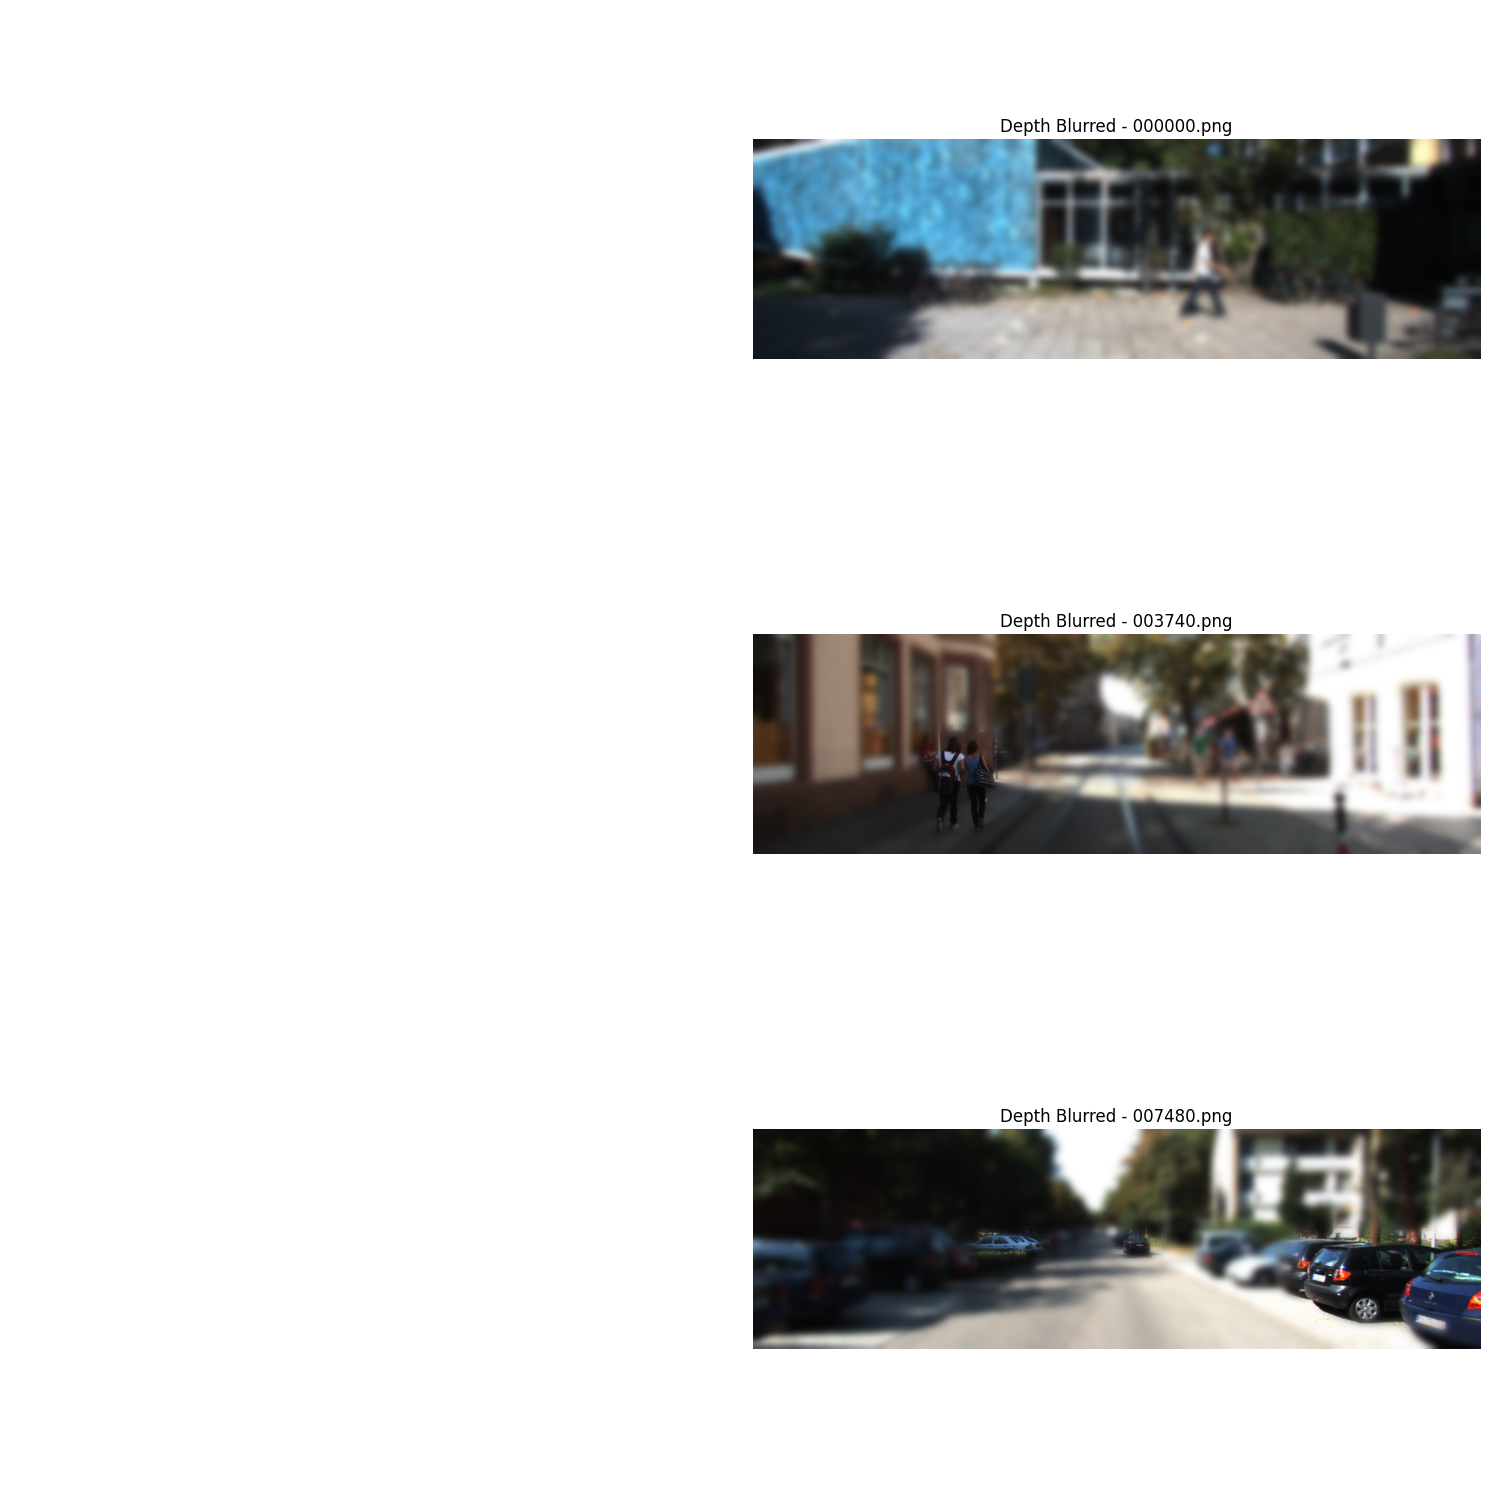


=== FINAL SUMMARY ===
Total images processed: 7481/7481
Output directory: /Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/BlurredImages/BlurredTrainingData

To review your results:
1. Navigate to the output directory
2. Compare original and blurred images
3. Objects at the correct focus distance should be sharp
4. Background and out-of-focus objects should be appropriately blurred
5. Edge transitions should be smooth and natural

Processing complete! Ready for your computer vision final project.


In [7]:
# This cell defines the image processing workflow and includes visualization of the results.
# It contains a function to process individual images, handles the entire dataset
# using parallel processing for speed, and then shows a few sample outputs.

def process_single_image(args):
    """
    Process a single image file.
    This function encapsulates the processing for a single image. It takes image
    and label filenames as arguments. It constructs full paths, checks if files exist,
    loads the image using cv2.imread, and parses the corresponding label file using
    parse_kitti_label.
    """
    image_filename, label_filename = args # Unpack arguments

    # Construct full paths to the image and its corresponding label file
    image_path = os.path.join(IMAGE_DIR, image_filename)
    label_path = os.path.join(LABEL_DIR, label_filename)

    # Check if both the image and label files exist
    if not os.path.exists(image_path) or not os.path.exists(label_path):
        return None # Return None if either file is missing

    # Load image using OpenCV
    image = cv2.imread(image_path)
    if image is None: # Check if image loading failed
        return None

    # Parse label file to get object information
    objects = parse_kitti_label(label_path)

    try:
        # Apply depth-based blur using the main blur function
        # It then calls apply_depth_blur with the image, objects, and the
        # effective_min and effective_max distances (calculated in Cell 5)
        # to get the blurred image.
        blurred_image = apply_depth_blur(image, objects, image_filename, effective_min, effective_max)

        # Save the processed (blurred) image to the output directory
        output_path = os.path.join(OUTPUT_DIR, image_filename)
        cv2.imwrite(output_path, blurred_image)
        return image_filename # Return the filename if processing was successful
    except Exception as e:
        # Error handling if it fails 
        print(f"Error processing {image_filename}: {e}")
        return None # Return None if an error occurred

# ---- Dataset Processing ----
# Get list of ALL images in the directory (sorted for consistent ordering)
# It gets a sorted list of all .png image files from IMAGE_DIR
all_image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
# and creates corresponding .txt label file names.
all_label_files = [f.replace('.png', '.txt') for f in all_image_files]

# It prints total images found and output directory.
print(f"\nFound {len(all_image_files)} total images to process")
print(f"Starting full dataset processing...")
print(f"Output directory: {OUTPUT_DIR}")

# Process all images with parallel processing
# It uses ThreadPoolExecutor for parallel processing of all images
num_cores = min(multiprocessing.cpu_count(), 8)  # Limit to 8 cores for stability to avoid overwhelming the system
print(f"Using {num_cores} cores for parallel processing...")

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    args_list = list(zip(all_image_files, all_label_files)) # Prepare arguments for each image
    # Execute process_single_image for all images in parallel,
    # showing progress with tqdm.
    results = list(tqdm(executor.map(process_single_image, args_list),
                       total=len(args_list),
                       desc="Processing all images",
                       unit="image"))

# ---- Results Summary & Visualization ----
# Count successful processes
# It counts and prints the number of successfully processed and failed images.
successful = sum(1 for r in results if r is not None)
print(f"\n=== PROCESSING COMPLETE ===")
print(f"Successfully processed {successful} out of {len(all_image_files)} images")
print(f"Failed to process: {len(all_image_files) - successful} images")
print(f"All blurred images saved to: {OUTPUT_DIR}")

# Create a visualization of a few sample results
def show_sample_results(num_samples=3):
    """
    Show a few sample results from the processed images.
    This function is defined to visualize results. It selects a few sample
    processed images (first, middle, and last from the sorted list in OUTPUT_DIR),
    loads the original and blurred versions, converts them to RGB, and displays
    them side-by-side using matplotlib.pyplot for comparison.
    """
    processed_files = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')])

    if len(processed_files) < num_samples: # Adjust if fewer images are processed than requested samples
        num_samples = len(processed_files)

    if num_samples == 0:
        print("No processed images found to display!")
        return

    # Take first, middle, and last images for a representative sample
    sample_indices = [0, len(processed_files)//2, -1]
    sample_files = [processed_files[i] for i in sample_indices[:num_samples]]

    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    if num_samples == 1: # Adjust subplot handling if only one sample is shown
        axes = axes.reshape(1, -1)

    for i, filename in enumerate(sample_files):
        # Load original image
        original_path = os.path.join(IMAGE_DIR, filename)
        original = cv2.imread(original_path)
        if original is not None:
            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib

            # Load blurred image
            blurred_path = os.path.join(OUTPUT_DIR, filename)
            blurred = cv2.imread(blurred_path)
            if blurred is not None:
                blurred_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

                # Plot comparison
                # axes[i, 0].imshow(original_rgb) # This line was commented out in the original notebook's output, so keeping it that way
                # axes[i, 0].set_title(f'Original - {filename}')
                axes[i, 0].axis('off') # Turn off axis for the (potentially empty) original image plot

                axes[i, 1].imshow(blurred_rgb)
                axes[i, 1].set_title(f'Depth Blurred - {filename}')
                axes[i, 1].axis('off') # Turn off axis for the blurred image plot

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plot

# Show some sample results
# It calls show_sample_results() to display three sample images.
print("\nShowing sample results...")
show_sample_results(3)

# Finally, it prints a summary of the processing and instructions for reviewing the results.
print(f"\n=== FINAL SUMMARY ===")
print(f"Total images processed: {successful}/{len(all_image_files)}")
print(f"Output directory: {OUTPUT_DIR}")
print("\nTo review your results:")
print("1. Navigate to the output directory")
print("2. Compare original and blurred images")
print("3. Objects at the correct focus distance should be sharp")
print("4. Background and out-of-focus objects should be appropriately blurred")
print("5. Edge transitions should be smooth and natural")

print("\nProcessing complete! Ready for your computer vision final project.")

In [ ]:
# # Count successful processes
# successful = sum(1 for r in results if r is not None)
# print(f"Successfully processed {successful} out of {len(image_files)} images")


In [ ]:
# ## Step 5: Visualization of Results
# def visualize_results(num_samples=3):
#     """Visualize original vs blurred images for comparison."""
#     processed_files = os.listdir(OUTPUT_DIR)
#     sample_files = np.random.choice(processed_files, min(num_samples, len(processed_files)), replace=False)
#     
#     fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
#     if num_samples == 1:
#         axes = axes.reshape(1, -1)
#     
#     for i, filename in enumerate(sample_files):
#         # Load original
#         original_path = os.path.join(IMAGE_DIR, filename)
#         original = cv2.imread(original_path)
#         original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
#         
#         # Load blurred
#         blurred_path = os.path.join(OUTPUT_DIR, filename)
#         blurred = cv2.imread(blurred_path)
#         blurred_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
#         
#         # Plot comparison
#         axes[i, 0].imshow(original_rgb)
#         axes[i, 0].set_title(f'Original - {filename}')
#         axes[i, 0].axis('off')
#         
#         axes[i, 1].imshow(blurred_rgb)
#         axes[i, 1].set_title(f'Depth Blurred - {filename}')
#         axes[i, 1].axis('off')
#     
#     plt.tight_layout()
#     plt.show()
# 
# # Visualize results
# visualize_results(3)
# 
# print("Processing complete! Blurred images saved to:", OUTPUT_DIR)